# **IMPORT LIBRARY**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

from imblearn.over_sampling import SMOTE

# **READ DATA**

## Data meaning
* index - Unique Identifier for each row
* trans_date_trans_time - Transaction DateTime
* cc_num - Credit Card Number of Customer
* merchant - Merchant Name
* category - Category of Merchant
* amt - Amount of Transaction
* first - First Name of Credit Card Holder
* last - Last Name of Credit Card Holder
* gender - Gender of Credit Card Holder
* street - Street Address of Credit Card Holder
* city - City of Credit Card Holder
* state - State of Credit Card Holder
* zip - Zip of Credit Card Holder (信用卡持有人的郵遞區號)
* lat - Latitude Location of Credit Card Holder (信用卡持卡人所在地緯度)
* long - Longitude Location of Credit Card Holder (信用卡持卡人所在地經度)
* city_pop - Credit Card Holder's City Population (持卡人居住地人口)
* job - Job of Credit Card Holder (持卡人生日)
* dob - Date of Birth of Credit Card Holder (持卡人生日)
* trans_num - Transaction Number
* unix_time - UNIX Time of transaction (時間)
* merch_lat - Latitude Location of Merchant
* merch_long - Longitude Location of Merchant
* is_fraud - Fraud Flag <--- Target **Class**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
original_data = pd.concat([pd.read_csv("/content/drive/MyDrive/Colab Notebooks/archive/fraudTrain.csv"),pd.read_csv("/content/drive/MyDrive/Colab Notebooks/archive/fraudTest.csv")])

In [4]:
print(original_data.info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1852394 non-null  int64  
 1   trans_date_trans_time  1852394 non-null  object 
 2   cc_num                 1852394 non-null  int64  
 3   merchant               1852394 non-null  object 
 4   category               1852394 non-null  object 
 5   amt                    1852394 non-null  float64
 6   first                  1852394 non-null  object 
 7   last                   1852394 non-null  object 
 8   gender                 1852394 non-null  object 
 9   street                 1852394 non-null  object 
 10  city                   1852394 non-null  object 
 11  state                  1852394 non-null  object 
 12  zip                    1852394 non-null  int64  
 13  lat                    1852394 non-null  float64
 14  long                   1

# **Preprocess**
透過下一段程式碼可以看到，兩個不同類別的占比相當不均勻，因此採用smoted和oversampling來解決此問題。

In [5]:
original_data = pd.DataFrame(original_data)
original_data = original_data.drop(columns=['Unnamed: 0','trans_date_trans_time'],axis = 1)

In [6]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

original_data["merchant"] = encoder.fit_transform(original_data["merchant"])
original_data["category"] = encoder.fit_transform(original_data["category"])
original_data["first"] = encoder.fit_transform(original_data["first"])
original_data["last"] = encoder.fit_transform(original_data["last"])
original_data["gender"] = encoder.fit_transform(original_data["gender"])
original_data["street"] = encoder.fit_transform(original_data["street"])
original_data["city"] = encoder.fit_transform(original_data["city"])
original_data["state"] = encoder.fit_transform(original_data["state"])
original_data["dob"] = encoder.fit_transform(original_data["dob"])
original_data["job"] = encoder.fit_transform(original_data["job"])
original_data["trans_num"] = encoder.fit_transform(original_data["trans_num"])

In [7]:
labels=["正常","詐騙"]

fraud_or_not = original_data["is_fraud"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=original_data['is_fraud'].value_counts(), names=labels , width=400, height=400, color_discrete_sequence=["#66AA00","black"]
             ,title="詐騙 vs 正常 訓練資料數量")
fig.show()

In [8]:
original_data.dtypes

cc_num          int64
merchant        int64
category        int64
amt           float64
first           int64
last            int64
gender          int64
street          int64
city            int64
state           int64
zip             int64
lat           float64
long          float64
city_pop        int64
job             int64
dob             int64
trans_num       int64
unix_time       int64
merch_lat     float64
merch_long    float64
is_fraud        int64
dtype: object

In [9]:
X = original_data.drop(columns=['is_fraud'],axis = 1 )
y = original_data['is_fraud']

Train_attribute,Test_attribute,Train_label,Test_label = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
smote = SMOTE()

Train_attribute_smote,Train_label_smote = smote.fit_resample(Train_attribute,Train_label)

In [11]:
labels=["正常","詐騙"]

fraud_or_not = Train_label_smote.value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=Train_label_smote.value_counts(), names=labels , width=400, height=400, color_discrete_sequence=["#66AA00","black"]
             ,title="詐騙 vs 正常 訓練資料數量")
fig.show()

### Function & Data about Prediction

In [12]:
all_predictions = pd.DataFrame() # 儲存所有預測結果

In [13]:
def model_accuracy(model,test_attribute,test_label,model_name,data_with,attribute_type): #預測準確率函數
  prediction = model.predict(test_attribute)

  print(confusion_matrix(test_label,prediction))
  print(classification_report(test_label,prediction))

  recall = recall_score(test_label, prediction)
  precision = precision_score(test_label, prediction)
  f1 = f1_score(test_label, prediction)
  accuracy = accuracy_score(test_label, prediction)

  arr = [(recall,precision,f1,accuracy)]
  score = pd.DataFrame(data = arr, columns=['Recall','Precision','F1 Score','Accuracy'])
  score.insert(0, 'Model', model_name)
  score.insert(1, 'Attribute type', attribute_type)
  score.insert(2, 'Data with', data_with)

  print(score)
  return score

# **Use Decision Tree to Find the Attribute's Importance**
嘗試運用決策數來找到資料屬性的重要性，並分常smoted跟un-smoted來運算決策樹。並將屬性對於模型重要性製作成圖表。

## Train Decision Tree Model

In [14]:
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [ ]:
DT_smote = DecisionTreeClassifier(criterion='log_loss')

In [ ]:
DT_smote_Model = DT_smote.fit(Train_attribute_smote,Train_label_smote)

In [ ]:
pr = model_accuracy(DT_smote_Model,Test_attribute,Test_label,'Decision Tree','Oversampling','All attribute')
all_predictions = pd.concat([all_predictions,pr],ignore_index=True)

[[541736  11045]
 [   655   2283]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    552781
           1       0.17      0.78      0.28      2938

    accuracy                           0.98    555719
   macro avg       0.59      0.88      0.64    555719
weighted avg       0.99      0.98      0.99    555719

           Model Attribute type     Data with    Recall  Precision  F1 Score  \
0  Decision Tree  All attribute  Oversampling  0.777059   0.171294  0.280708   

   Accuracy  
0  0.978946  


In [ ]:
DT_normal = DecisionTreeClassifier(criterion='log_loss')

In [ ]:
DT_normal_Model = DT_normal.fit(Train_attribute,Train_label)

In [ ]:
pr = model_accuracy(DT_normal_Model,Test_attribute,Test_label,'Decision Tree','UnOversampling','All attribute')
all_predictions = pd.concat([all_predictions,pr],ignore_index=True)

[[551771   1010]
 [   896   2042]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552781
           1       0.67      0.70      0.68      2938

    accuracy                           1.00    555719
   macro avg       0.83      0.85      0.84    555719
weighted avg       1.00      1.00      1.00    555719

           Model Attribute type       Data with    Recall  Precision  \
0  Decision Tree  All attribute  UnOversampling  0.695031   0.669069   

   F1 Score  Accuracy  
0  0.681803   0.99657  


In [ ]:
all_predictions

,Model,Attribute type,Data with,Recall,Precision,F1 Score,Accuracy
0,Decision Tree,All attribute,Oversampling,0.777059,0.171294,0.280708,0.978946
1,Decision Tree,All attribute,UnOversampling,0.695031,0.669069,0.681803,0.996570


## Find Importance of Attributes

In [ ]:
feature = Train_attribute_smote.columns
print(type(feature))

<class 'pandas.core.indexes.base.Index'>


In [ ]:
arr_smote = list(zip(feature,DT_smote_Model.feature_importances_))
arr_smote = sorted(arr_smote,key = lambda x:x[1])[::-1]
arr_smote = np.array(arr_smote)
print(arr_smote.shape)

arr_normal = list(zip(feature,DT_normal_Model.feature_importances_))
arr_normal = sorted(arr_normal,key = lambda x:x[1])[::-1]
arr_normal = np.array(arr_normal)
print(arr_normal.shape)

(20, 2)
(20, 2)


<function matplotlib.pyplot.show(close=None, block=None)>

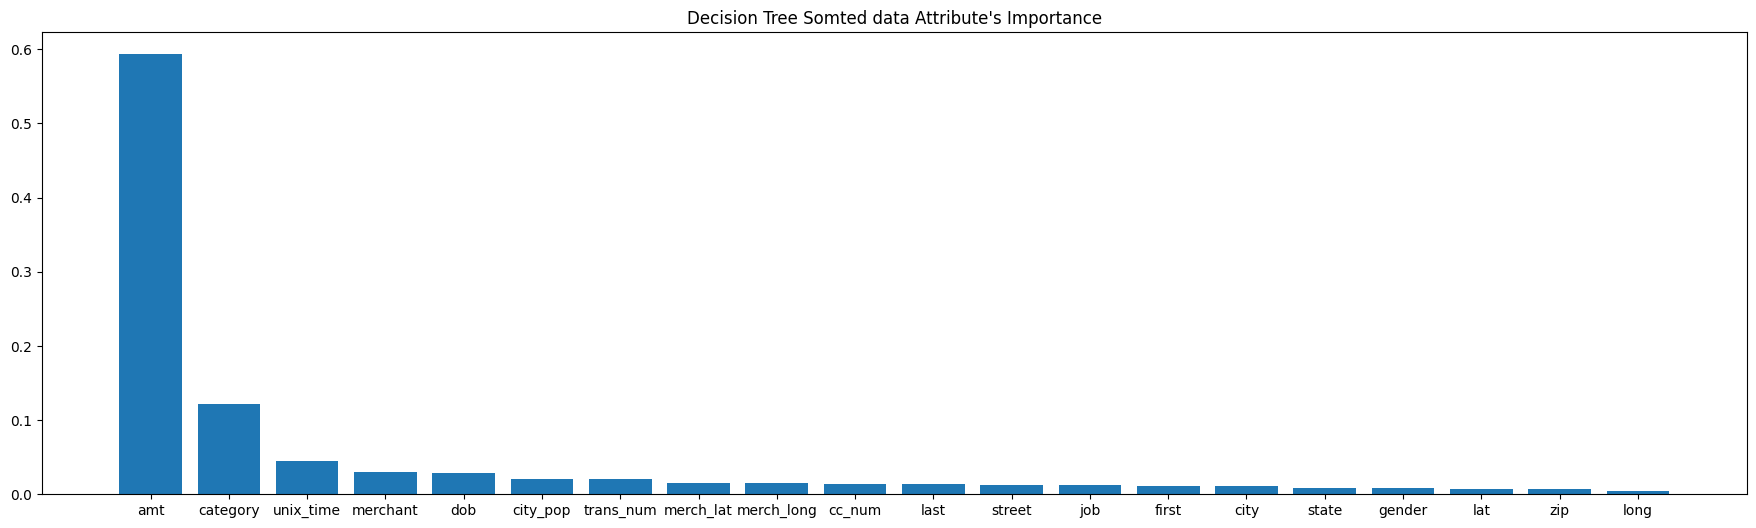

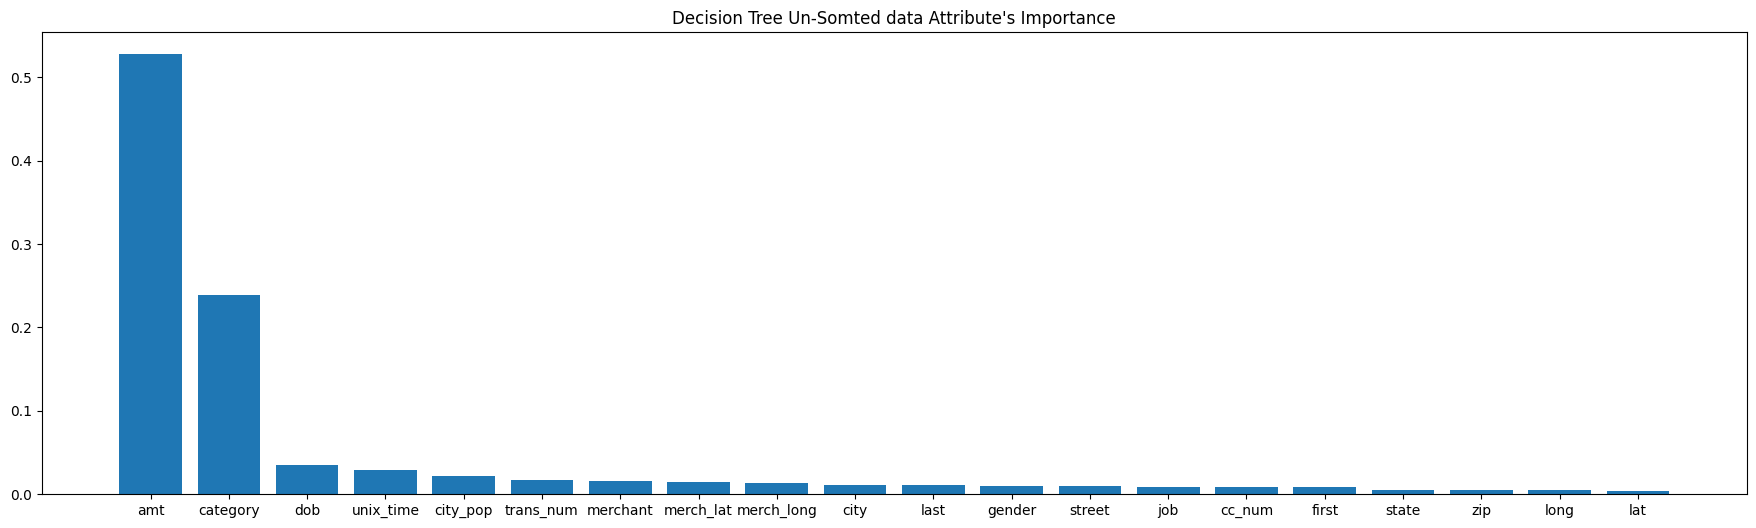

In [ ]:
x_smote = arr_smote[:,0]
y_smote = []

for i in range(0,20,1):
  y_smote.append(float(arr_smote[i,1]))

plt.figure(figsize=(22, 6))
plt.title("Decision Tree Somted data Attribute's Importance")
plt.bar(x_smote,y_smote)
plt.show

x_normal = arr_normal[:,0]
y_normal = []

for i in range(0,20,1):
  y_normal.append(float(arr_normal[i,1]))

plt.figure(figsize=(22, 6))
plt.title("Decision Tree Un-Somted data Attribute's Importance")
plt.bar(x_normal,y_normal)
plt.show

In [ ]:
from tabulate import tabulate
table = [arr_smote[:,0],arr_normal[:,0]]
table = pd.DataFrame(table).transpose()

print(tabulate(table,headers = ['Smote','Un-Smote'],tablefmt='fancy_grid'))

╒════╤════════════╤════════════╕
│    │ Smote      │ Un-Smote   │
╞════╪════════════╪════════════╡
│  0 │ amt        │ amt        │
├────┼────────────┼────────────┤
│  1 │ category   │ category   │
├────┼────────────┼────────────┤
│  2 │ unix_time  │ dob        │
├────┼────────────┼────────────┤
│  3 │ merchant   │ unix_time  │
├────┼────────────┼────────────┤
│  4 │ dob        │ city_pop   │
├────┼────────────┼────────────┤
│  5 │ city_pop   │ trans_num  │
├────┼────────────┼────────────┤
│  6 │ trans_num  │ merchant   │
├────┼────────────┼────────────┤
│  7 │ merch_lat  │ merch_lat  │
├────┼────────────┼────────────┤
│  8 │ merch_long │ merch_long │
├────┼────────────┼────────────┤
│  9 │ cc_num     │ city       │
├────┼────────────┼────────────┤
│ 10 │ last       │ last       │
├────┼────────────┼────────────┤
│ 11 │ street     │ gender     │
├────┼────────────┼────────────┤
│ 12 │ job        │ street     │
├────┼────────────┼────────────┤
│ 13 │ first      │ job        │
├────┼────

## Find Best TOP Atrributes

In [ ]:
attributeList = np.array(arr_normal[:,0])

recall_score_x = []

for i in range(0,len(attributeList)-1,1):

  temp = []
  temp.append('is_fraud')
  for j in range(len(attributeList)-1,i,-1):
    temp.append(attributeList[j])

  X = original_data.drop(columns=temp,axis=1)
  y = original_data['is_fraud']
  print(X.columns)

  Train_attribute,Test_attribute,Train_label,Test_label = train_test_split(X, y, test_size=0.3)

  x_train,y_train = smote.fit_resample(Train_attribute,Train_label)

  DT_smote = DecisionTreeClassifier(criterion='log_loss',splitter='best')
  DT_smote_Model = DT_smote.fit(x_train,y_train)
  y_prediction_smote = DT_smote_Model.predict(Test_attribute)

  score = recall_score(Test_label, y_prediction_smote)
  recall_score_x.append(score)
  print('Recall score',score)

Index(['amt'], dtype='object')
Recall score 0.5300207039337475
Index(['category', 'amt'], dtype='object')
Recall score 0.7795031055900621
Index(['category', 'amt', 'dob'], dtype='object')
Recall score 0.7473009446693657
Index(['category', 'amt', 'dob', 'unix_time'], dtype='object')
Recall score 0.822993340343498
Index(['category', 'amt', 'city_pop', 'dob', 'unix_time'], dtype='object')
Recall score 0.8337865397688647
Index(['category', 'amt', 'city_pop', 'dob', 'trans_num', 'unix_time'], dtype='object')
Recall score 0.7908799429996437
Index(['merchant', 'category', 'amt', 'city_pop', 'dob', 'trans_num',
       'unix_time'],
      dtype='object')
Recall score 0.7526501766784452
Index(['merchant', 'category', 'amt', 'city_pop', 'dob', 'trans_num',
       'unix_time', 'merch_lat'],
      dtype='object')
Recall score 0.7668252889191026
Index(['merchant', 'category', 'amt', 'city_pop', 'dob', 'trans_num',
       'unix_time', 'merch_lat', 'merch_long'],
      dtype='object')
Recall score 0.7

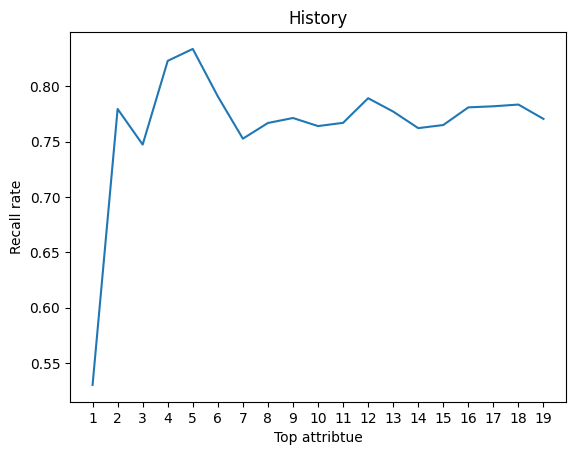

In [ ]:
plt.plot(range(1,20,1),recall_score_x)
plt.title('History')
plt.xlabel('Top attribtue')
plt.xticks(range(1, 20, 1))
plt.ylabel('Recall rate')
plt.show()

# Training

## Re-Preprocess Data


In [15]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 555718
Data columns (total 21 columns):
 #   Column      Dtype  
---  ------      -----  
 0   cc_num      int64  
 1   merchant    int64  
 2   category    int64  
 3   amt         float64
 4   first       int64  
 5   last        int64  
 6   gender      int64  
 7   street      int64  
 8   city        int64  
 9   state       int64  
 10  zip         int64  
 11  lat         float64
 12  long        float64
 13  city_pop    int64  
 14  job         int64  
 15  dob         int64  
 16  trans_num   int64  
 17  unix_time   int64  
 18  merch_lat   float64
 19  merch_long  float64
 20  is_fraud    int64  
dtypes: float64(5), int64(16)
memory usage: 310.9 MB


In [16]:
X_Listed_important = original_data.drop(columns=['is_fraud','city','trans_num','merch_lat','merchant','merch_lat','merch_long','last','cc_num','street','gender','job','first','long','state','zip','lat'],axis = 1 )
y_Listed_important = original_data['is_fraud']

X_manually = original_data.drop(columns=['is_fraud','city_pop','trans_num','last','cc_num','street','first','long','zip','lat','merch_lat','merch_long'],axis = 1)
y_manually = original_data['is_fraud']

Train_attribute_Listed,Test_attribute_Listed,Train_label_Listed,Test_label_Listed = train_test_split(X_Listed_important, y_Listed_important, test_size=0.3)
Train_attribute_manually,Test_attribute_manually,Train_label_manually,Test_label_manually = train_test_split(X_manually, y_manually, test_size=0.3)

In [17]:
print(X_Listed_important.info(),end='\n\n')
print(X_manually.info(),end='\n\n')
print("*"*100,end='\n\n')
print(Train_attribute_Listed.info(),end='\n\n')
print(Train_label_Listed.info(),end='\n\n')
print(Train_attribute_manually.info(),end='\n\n')
print(Train_label_manually.info(),end='\n\n')
print("*"*100)

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 555718
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   category   int64  
 1   amt        float64
 2   city_pop   int64  
 3   dob        int64  
 4   unix_time  int64  
dtypes: float64(1), int64(4)
memory usage: 84.8 MB
None

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 555718
Data columns (total 9 columns):
 #   Column     Dtype  
---  ------     -----  
 0   merchant   int64  
 1   category   int64  
 2   amt        float64
 3   gender     int64  
 4   city       int64  
 5   state      int64  
 6   job        int64  
 7   dob        int64  
 8   unix_time  int64  
dtypes: float64(1), int64(8)
memory usage: 141.3 MB
None

****************************************************************************************************

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 173969 to 871233
Data columns (total 5 columns):
 #   Column     Non-Null Cou

In [18]:
labels=["正常","詐騙"]

fraud_or_not = Train_label_Listed.value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=Train_label_Listed.value_counts(), names=labels , width=400, height=400, color_discrete_sequence=["#66AA00","black"]
             ,title="詐騙 vs 正常 訓練資料數量")
fig.show()

In [19]:
smote = SMOTE()

Train_attribute_Listed_smote,Train_label_Listed_smote = smote.fit_resample(Train_attribute_Listed,Train_label_Listed)
Train_attribute_manually_smote,Train_label_manually_smote = smote.fit_resample(Train_attribute_manually,Train_label_manually)

In [20]:
labels=["正常","詐騙"]

fraud_or_not = Train_label_Listed_smote.value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=Train_label_Listed_smote.value_counts(), names=labels , width=400, height=400, color_discrete_sequence=["#66AA00","black"]
             ,title="詐騙 vs 正常 訓練資料數量")
fig.show()

## Train Model

### Decision Tree

#### Listed,Oversampling

In [ ]:
DT_smote = DecisionTreeClassifier(criterion='log_loss',splitter='best')

In [ ]:
DT_smote_Model = DT_smote.fit(Train_attribute_Listed_smote,Train_label_Listed_smote)

In [ ]:
pr = model_accuracy(DT_smote_Model,Test_attribute_Listed,Test_label_Listed,'Decision Tree','Oversampling','Listed')
all_predictions = pd.concat([all_predictions,pr])

[[539921  12886]
 [   492   2420]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    552807
           1       0.16      0.83      0.27      2912

    accuracy                           0.98    555719
   macro avg       0.58      0.90      0.63    555719
weighted avg       0.99      0.98      0.98    555719

           Model Attribute type     Data with    Recall  Precision  F1 Score  \
0  Decision Tree         Listed  Oversampling  0.831044   0.158108  0.265671   

   Accuracy  
0  0.975927  


In [ ]:
all_predictions

,Model,Attribute type,Data with,Recall,Precision,F1 Score,Accuracy
0,Decision Tree,All attribute,Oversampling,0.777059,0.171294,0.280708,0.978946
1,Decision Tree,All attribute,UnOversampling,0.695031,0.669069,0.681803,0.996570
0,Decision Tree,Listed,Oversampling,0.831044,0.158108,0.265671,0.975927


#### Listed,Non-oversampling

In [ ]:
DT_unsmote = DecisionTreeClassifier(criterion='log_loss',splitter='best')

In [ ]:
DT_unsmote_Model = DT_unsmote.fit(Train_attribute_Listed,Train_label_Listed)

In [ ]:
pr = model_accuracy(DT_unsmote,Test_attribute_Listed,Test_label_Listed,'Decision Tree','UnOversampling','Listed')
all_predictions = pd.concat([all_predictions,pr],ignore_index=True)

[[551828    979]
 [   887   2025]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552807
           1       0.67      0.70      0.68      2912

    accuracy                           1.00    555719
   macro avg       0.84      0.85      0.84    555719
weighted avg       1.00      1.00      1.00    555719

           Model Attribute type       Data with    Recall  Precision  \
0  Decision Tree         Listed  UnOversampling  0.695398   0.674101   

   F1 Score  Accuracy  
0  0.684584  0.996642  


In [ ]:
all_predictions

,Model,Attribute type,Data with,Recall,Precision,F1 Score,Accuracy
0,Decision Tree,All attribute,Oversampling,0.777059,0.171294,0.280708,0.978946
1,Decision Tree,All attribute,UnOversampling,0.695031,0.669069,0.681803,0.996570
2,Decision Tree,Listed,Oversampling,0.831044,0.158108,0.265671,0.975927
3,Decision Tree,Listed,UnOversampling,0.695398,0.674101,0.684584,0.996642


#### Maually,Oversampling

In [ ]:
DT_smote = DecisionTreeClassifier(criterion='log_loss',splitter='best')

In [ ]:
DT_smote_Model = DT_smote.fit(Train_attribute_manually_smote,Train_label_manually_smote)

In [ ]:
pr = model_accuracy(DT_smote_Model,Test_attribute_manually,Test_label_manually,'Decision Tree','Oversampling','Manually')
all_predictions = pd.concat([all_predictions,pr])

[[543477   9322]
 [   666   2254]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    552799
           1       0.19      0.77      0.31      2920

    accuracy                           0.98    555719
   macro avg       0.60      0.88      0.65    555719
weighted avg       0.99      0.98      0.99    555719

           Model Attribute type     Data with    Recall  Precision  F1 Score  \
0  Decision Tree       Manually  Oversampling  0.771918   0.194713  0.310982   

   Accuracy  
0  0.982027  


In [ ]:
all_predictions

,Model,Attribute type,Data with,Recall,Precision,F1 Score,Accuracy
0,Decision Tree,All attribute,Oversampling,0.777059,0.171294,0.280708,0.978946
1,Decision Tree,All attribute,UnOversampling,0.695031,0.669069,0.681803,0.996570
2,Decision Tree,Listed,Oversampling,0.831044,0.158108,0.265671,0.975927
3,Decision Tree,Listed,UnOversampling,0.695398,0.674101,0.684584,0.996642
0,Decision Tree,Manually,Oversampling,0.771918,0.194713,0.310982,0.982027


#### Manually,Non-oversampling

In [ ]:
DT_unsmote = DecisionTreeClassifier(criterion='log_loss',splitter='best')

In [ ]:
DT_unsmote_Model = DT_unsmote.fit(Train_attribute_manually,Train_label_manually)

In [ ]:
pr = model_accuracy(DT_unsmote,Test_attribute_manually,Test_label_manually,'Decision Tree','UnOversampling','Manually')
all_predictions = pd.concat([all_predictions,pr],ignore_index=True)

[[551751   1048]
 [  1012   1908]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552799
           1       0.65      0.65      0.65      2920

    accuracy                           1.00    555719
   macro avg       0.82      0.83      0.82    555719
weighted avg       1.00      1.00      1.00    555719

           Model Attribute type       Data with    Recall  Precision  \
0  Decision Tree       Manually  UnOversampling  0.653425   0.645467   

   F1 Score  Accuracy  
0  0.649421  0.996293  


In [ ]:
all_predictions

,Model,Attribute type,Data with,Recall,Precision,F1 Score,Accuracy
0,Decision Tree,All attribute,Oversampling,0.777059,0.171294,0.280708,0.978946
1,Decision Tree,All attribute,UnOversampling,0.695031,0.669069,0.681803,0.996570
2,Decision Tree,Listed,Oversampling,0.831044,0.158108,0.265671,0.975927
3,Decision Tree,Listed,UnOversampling,0.695398,0.674101,0.684584,0.996642
4,Decision Tree,Manually,Oversampling,0.771918,0.194713,0.310982,0.982027
5,Decision Tree,Manually,UnOversampling,0.653425,0.645467,0.649421,0.996293


### KNN

#### Find best n_neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

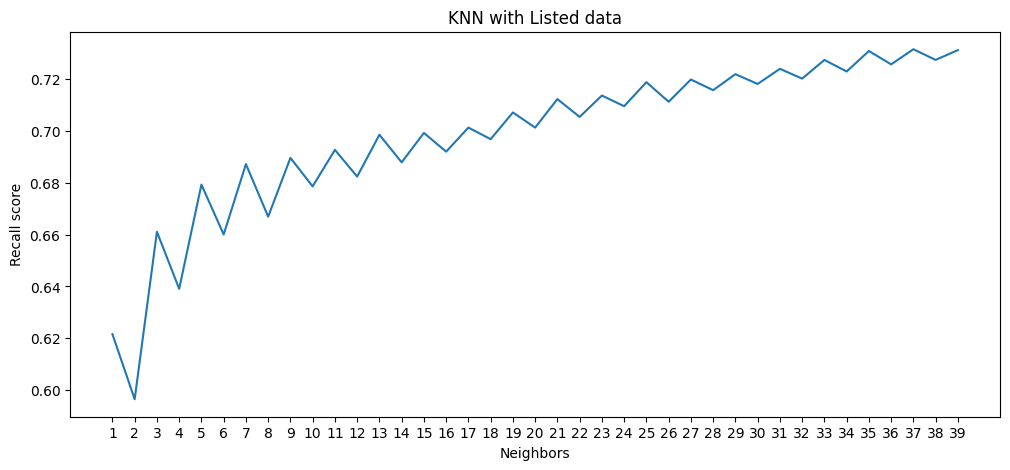

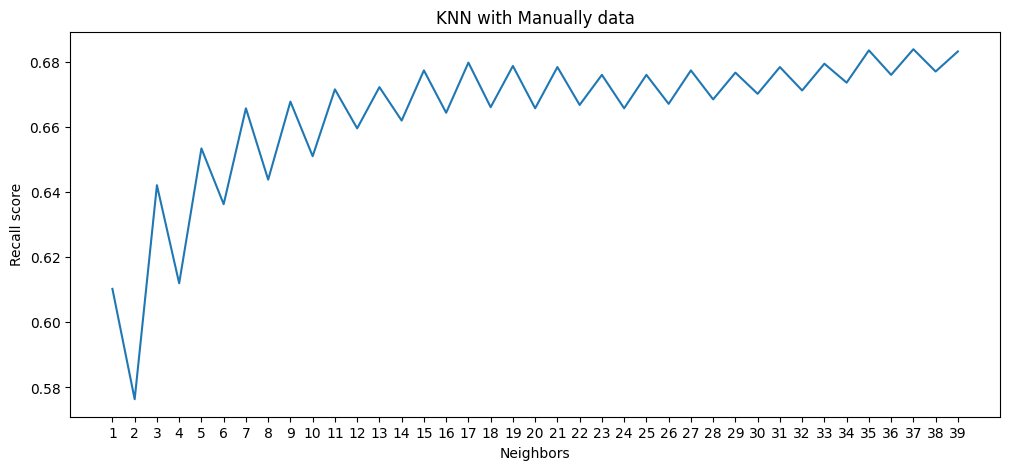

In [ ]:
y = []

for i in range(1,40,1):
  model = KNeighborsClassifier(n_neighbors = i)
  model.fit(Train_attribute_Listed_smote,Train_label_Listed_smote)
  prediction = model.predict(Test_attribute_Listed)
  recall = recall_score(Test_label_Listed, prediction)
  y.append(recall)

plt.figure(figsize=(12, 5))
plt.plot(range(1,40,1),y)
plt.title('KNN with Listed data')
plt.xlabel('Neighbors')
plt.xticks(range(1,40,1))
plt.ylabel('Recall score')
plt.show()


y = []

for i in range(1,40,1):
  model = KNeighborsClassifier(n_neighbors = i)
  model.fit(Train_attribute_manually_smote,Train_label_manually_smote)
  prediction = model.predict(Test_attribute_manually)
  recall = recall_score(Test_label_manually, prediction)
  y.append(recall)

plt.figure(figsize=(12, 5))
plt.plot(range(1,40,1),y)
plt.title('KNN with Manually data')
plt.xlabel('Neighbors')
plt.xticks(range(1,40,1))
plt.ylabel('Recall score')
plt.show()

#### Listed,Oversampling

In [ ]:
model = KNeighborsClassifier(n_neighbors = 40)
model.fit(Train_attribute_Listed_smote,Train_label_Listed_smote)

pr = model_accuracy(model,Test_attribute_Listed,Test_label_Listed,'KNN','Oversampling','Listed')
all_predictions = pd.concat([all_predictions,pr],ignore_index=True)

[[489930  62877]
 [   793   2119]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    552807
           1       0.03      0.73      0.06      2912

    accuracy                           0.89    555719
   macro avg       0.52      0.81      0.50    555719
weighted avg       0.99      0.89      0.93    555719

  Model Attribute type     Data with    Recall  Precision  F1 Score  Accuracy
0   KNN         Listed  Oversampling  0.727679   0.032602  0.062408  0.885428


#### Listed,Non-oversampling

In [ ]:
model = KNeighborsClassifier(n_neighbors = 40)
model.fit(Train_attribute_Listed,Train_label_Listed)

pr = model_accuracy(model,Test_attribute_Listed,Test_label_Listed,'KNN','UnOversampling','Listed')
all_predictions = pd.concat([all_predictions,pr],ignore_index=True)

[[552807      0]
 [  2912      0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.99      1.00      1.00    552807
           1       0.00      0.00      0.00      2912

    accuracy                           0.99    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      0.99      0.99    555719



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



  Model Attribute type       Data with  Recall  Precision  F1 Score  Accuracy
0   KNN         Listed  UnOversampling     0.0        0.0       0.0   0.99476


#### Manually,oversampling

In [ ]:
model = KNeighborsClassifier(n_neighbors = 40)
model.fit(Train_attribute_manually_smote,Train_label_manually_smote)

pr = model_accuracy(model,Test_attribute_manually,Test_label_manually,'KNN','Oversampling','Manually')
all_predictions = pd.concat([all_predictions,pr],ignore_index=True)

[[490675  62124]
 [   934   1986]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    552799
           1       0.03      0.68      0.06      2920

    accuracy                           0.89    555719
   macro avg       0.51      0.78      0.50    555719
weighted avg       0.99      0.89      0.93    555719

  Model Attribute type     Data with    Recall  Precision  F1 Score  Accuracy
0   KNN       Manually  Oversampling  0.680137   0.030978  0.059257  0.886529


#### Manually,Non-oversampling

In [ ]:
model = KNeighborsClassifier(n_neighbors = 40)
model.fit(Train_attribute_manually,Train_label_manually)

pr = model_accuracy(model,Test_attribute_manually,Test_label_manually,'KNN','UnOversampling','Manually')
all_predictions = pd.concat([all_predictions,pr],ignore_index=True)

[[552799      0]
 [  2920      0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.99      1.00      1.00    552799
           1       0.00      0.00      0.00      2920

    accuracy                           0.99    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      0.99      0.99    555719



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



  Model Attribute type       Data with  Recall  Precision  F1 Score  Accuracy
0   KNN       Manually  UnOversampling     0.0        0.0       0.0  0.994746


In [ ]:
all_predictions

,Model,Attribute type,Data with,Recall,Precision,F1 Score,Accuracy
0,Decision Tree,All attribute,Oversampling,0.777059,0.171294,0.280708,0.978946
1,Decision Tree,All attribute,UnOversampling,0.695031,0.669069,0.681803,0.996570
2,Decision Tree,Listed,Oversampling,0.831044,0.158108,0.265671,0.975927
3,Decision Tree,Listed,UnOversampling,0.695398,0.674101,0.684584,0.996642
4,Decision Tree,Manually,Oversampling,0.771918,0.194713,0.310982,0.982027
5,Decision Tree,Manually,UnOversampling,0.653425,0.645467,0.649421,0.996293
6,KNN,Listed,Oversampling,0.727679,0.032602,0.062408,0.885428
7,KNN,Listed,UnOversampling,0.000000,0.000000,0.000000,0.994760
8,KNN,Manually,Oversampling,0.680137,0.030978,0.059257,0.886529
9,KNN,Manually,UnOversampling,0.000000,0.000000,0.000000,0.994746


### 類神經

In [21]:
from sklearn.neural_network import MLPClassifier

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(Train_attribute_Listed_smote)
Train_attribute_Listed_smote_tran = scaler.transform(Train_attribute_Listed_smote)
Test_attribute_Listed_smote_tran = scaler.transform(Test_attribute_Listed)

scaler2 = StandardScaler()
scaler2.fit(Train_attribute_Listed)
Train_attribute_Listed_tran = scaler2.transform(Train_attribute_Listed)
Test_attribute_Listed_tran = scaler2.transform(Test_attribute_Listed)

scaler3 = StandardScaler()
scaler3.fit(Train_attribute_manually_smote)
Train_attribute_manually_smote_tran = scaler3.transform(Train_attribute_manually_smote)
Test_attribute_manually_smote_tran = scaler3.transform(Test_attribute_manually)

scaler4 = StandardScaler()
scaler4.fit(Train_attribute_manually)
Train_attribute_manually_tran = scaler4.transform(Train_attribute_manually)
Test_attribute_manually_tran = scaler4.transform(Test_attribute_manually)

#### Listed,oversampling

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(20,20,20),max_iter=70000)
model.fit(Train_attribute_Listed_smote_tran,Train_label_Listed_smote)

MLPClassifier(hidden_layer_sizes=(20, 20, 20), max_iter=70000)

In [ ]:
pr = model_accuracy(model,Test_attribute_Listed_smote_tran,Test_label_Listed,'Neural network','Oversampling','Listed')
all_predictions = pd.concat([all_predictions,pr],ignore_index=True)

[[529193  23614]
 [   341   2571]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    552807
           1       0.10      0.88      0.18      2912

    accuracy                           0.96    555719
   macro avg       0.55      0.92      0.58    555719
weighted avg       0.99      0.96      0.97    555719

            Model Attribute type     Data with    Recall  Precision  F1 Score  \
0  Neural network         Listed  Oversampling  0.882898   0.098186  0.176719   

   Accuracy  
0  0.956894  


In [ ]:
copy = all_predictions

#### Listed,unoversampling

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(20,20,20),max_iter=70000)
model.fit(Train_attribute_Listed_tran,Train_label_Listed)

MLPClassifier(hidden_layer_sizes=(20, 20, 20), max_iter=70000)

In [ ]:
pr = model_accuracy(model,Test_attribute_Listed_tran,Test_label_Listed,'Neural network','UnOversampling','Listed')
all_predictions = pd.concat([all_predictions,pr],ignore_index=True)

[[552344    463]
 [  1075   1837]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552807
           1       0.80      0.63      0.70      2912

    accuracy                           1.00    555719
   macro avg       0.90      0.82      0.85    555719
weighted avg       1.00      1.00      1.00    555719

            Model Attribute type       Data with    Recall  Precision  \
0  Neural network         Listed  UnOversampling  0.630838   0.798696   

   F1 Score  Accuracy  
0  0.704912  0.997232  


#### Manually,oversmapling

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(20,20,20),max_iter=70000)
model.fit(Train_attribute_manually_smote_tran,Train_label_manually_smote)

MLPClassifier(hidden_layer_sizes=(20, 20, 20), max_iter=70000)

In [ ]:
pr = model_accuracy(model,Test_attribute_manually_smote_tran,Test_label_manually,'Neural network','Oversampling','Manually')
all_predictions = pd.concat([all_predictions,pr],ignore_index=True)

[[521300  31499]
 [   408   2512]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    552799
           1       0.07      0.86      0.14      2920

    accuracy                           0.94    555719
   macro avg       0.54      0.90      0.55    555719
weighted avg       0.99      0.94      0.97    555719

            Model Attribute type     Data with    Recall  Precision  F1 Score  \
0  Neural network       Manually  Oversampling  0.860274   0.073858  0.136037   

   Accuracy  
0  0.942584  


#### Manually,Non-oversmapling

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(20,20,20),max_iter=70000)
model.fit(Train_attribute_manually_tran,Train_label_manually)

MLPClassifier(hidden_layer_sizes=(20, 20, 20), max_iter=70000)

In [ ]:
pr = model_accuracy(model,Test_attribute_manually_tran,Test_label_manually,'Neural network','UnOversampling','Manually')
all_predictions = pd.concat([all_predictions,pr],ignore_index=True)

[[552351    448]
 [  1156   1764]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552799
           1       0.80      0.60      0.69      2920

    accuracy                           1.00    555719
   macro avg       0.90      0.80      0.84    555719
weighted avg       1.00      1.00      1.00    555719

            Model Attribute type       Data with   Recall  Precision  \
0  Neural network       Manually  UnOversampling  0.60411   0.797468   

   F1 Score  Accuracy  
0  0.687451  0.997114  


In [ ]:
all_predictions

,Model,Attribute type,Data with,Recall,Precision,F1 Score,Accuracy
0,Decision Tree,All attribute,Oversampling,0.777059,0.171294,0.280708,0.978946
1,Decision Tree,All attribute,UnOversampling,0.695031,0.669069,0.681803,0.996570
2,Decision Tree,Listed,Oversampling,0.831044,0.158108,0.265671,0.975927
3,Decision Tree,Listed,UnOversampling,0.695398,0.674101,0.684584,0.996642
4,Decision Tree,Manually,Oversampling,0.771918,0.194713,0.310982,0.982027
5,Decision Tree,Manually,UnOversampling,0.653425,0.645467,0.649421,0.996293
6,KNN,Listed,Oversampling,0.727679,0.032602,0.062408,0.885428
7,KNN,Listed,UnOversampling,0.000000,0.000000,0.000000,0.994760
8,KNN,Manually,Oversampling,0.680137,0.030978,0.059257,0.886529
9,KNN,Manually,UnOversampling,0.000000,0.000000,0.000000,0.994746


### Bagging

In [23]:
from sklearn.ensemble import BaggingClassifier

#### use DT as classifier

##### Listed,Oversampling

In [ ]:
bagging_model = BaggingClassifier(DecisionTreeClassifier(criterion='log_loss',splitter='best'),n_estimators=20,n_jobs=-1)
bagging_model.fit(Train_attribute_Listed_smote,Train_label_Listed_smote)

pr = model_accuracy(bagging_model,Test_attribute_Listed,Test_label_Listed,'Bagging+DT','Oversampling','Listed')
all_predictions = pd.concat([all_predictions,pr],ignore_index=True)

[[544761   8046]
 [   444   2468]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    552807
           1       0.23      0.85      0.37      2912

    accuracy                           0.98    555719
   macro avg       0.62      0.92      0.68    555719
weighted avg       1.00      0.98      0.99    555719

     Model Attribute type     Data with    Recall  Precision  F1 Score  \
0  Bagging         Listed  Oversampling  0.847527   0.234735  0.367645   

   Accuracy  
0  0.984722  


##### Manually,oversampling

In [ ]:
bagging_model = BaggingClassifier(DecisionTreeClassifier(criterion='log_loss',splitter='best'),n_estimators=20,n_jobs=-1)
bagging_model.fit(Train_attribute_manually_smote,Train_label_manually_smote)

pr = model_accuracy(bagging_model,Test_attribute_manually,Test_label_manually,'Bagging+DT','Oversampling','Manually')
all_predictions = pd.concat([all_predictions,pr],ignore_index=True)

[[547507   5292]
 [   568   2352]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    552799
           1       0.31      0.81      0.45      2920

    accuracy                           0.99    555719
   macro avg       0.65      0.90      0.72    555719
weighted avg       1.00      0.99      0.99    555719

     Model Attribute type     Data with    Recall  Precision  F1 Score  \
0  Bagging       Manually  Oversampling  0.805479   0.307692  0.445286   

   Accuracy  
0  0.989455  


#### use NT as classifier

##### Listed,oversampling

In [ ]:
bagging_model = BaggingClassifier(MLPClassifier(hidden_layer_sizes=(20,20,20),max_iter=70000),n_estimators=11,n_jobs=-1)
bagging_model.fit(Train_attribute_Listed_smote_tran,Train_label_Listed_smote)

pr = model_accuracy(bagging_model,Test_attribute_Listed_smote_tran,Test_label_Listed,'Bagging+NT','Oversampling','Listed')
all_predictions = pd.concat([all_predictions,pr],ignore_index=True)

[[532489  20323]
 [   344   2563]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    552812
           1       0.11      0.88      0.20      2907

    accuracy                           0.96    555719
   macro avg       0.56      0.92      0.59    555719
weighted avg       0.99      0.96      0.98    555719

        Model Attribute type     Data with    Recall  Precision  F1 Score  \
0  Bagging+NT         Listed  Oversampling  0.881665    0.11199  0.198736   

   Accuracy  
0   0.96281  


##### Manuually,oversampling

In [24]:
bagging_model = BaggingClassifier(MLPClassifier(hidden_layer_sizes=(20,20,20),max_iter=70000),n_estimators=11,n_jobs=-1)
bagging_model.fit(Train_attribute_manually_smote_tran,Train_label_manually_smote)

pr = model_accuracy(bagging_model,Test_attribute_manually_smote_tran,Test_label_manually,'Bagging+NT','Oversampling','Listed')
all_predictions = pd.concat([all_predictions,pr],ignore_index=True)

[[535511  17378]
 [   402   2428]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    552889
           1       0.12      0.86      0.21      2830

    accuracy                           0.97    555719
   macro avg       0.56      0.91      0.60    555719
weighted avg       0.99      0.97      0.98    555719

        Model Attribute type     Data with    Recall  Precision  F1 Score  \
0  Bagging+NT         Listed  Oversampling  0.857951   0.122589  0.214526   

   Accuracy  
0  0.968005  


##### Listed,non-oversampling

In [ ]:
bagging_model = BaggingClassifier(MLPClassifier(hidden_layer_sizes=(20,20,20),max_iter=70000),n_estimators=21,n_jobs=-1)
bagging_model.fit(Train_attribute_Listed_tran,Train_label_Listed)

pr = model_accuracy(bagging_model,Test_attribute_Listed_tran,Test_label_Listed,'Bagging+NT','UnOversampling','Listed')
all_predictions = pd.concat([all_predictions,pr],ignore_index=True)

[[552375    437]
 [  1077   1830]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552812
           1       0.81      0.63      0.71      2907

    accuracy                           1.00    555719
   macro avg       0.90      0.81      0.85    555719
weighted avg       1.00      1.00      1.00    555719

        Model Attribute type       Data with    Recall  Precision  F1 Score  \
0  Bagging+NT         Listed  UnOversampling  0.629515   0.807234  0.707383   

   Accuracy  
0  0.997276  


#### Result

In [36]:
all_predictions

,Model,Attribute type,Data with,Recall,Precision,F1 Score,Accuracy
0,Decision Tree,All attribute,Oversampling,0.777059,0.171294,0.280708,0.978946
1,Decision Tree,All attribute,UnOversampling,0.695031,0.669069,0.681803,0.996570
2,Decision Tree,Listed,Oversampling,0.831044,0.158108,0.265671,0.975927
3,Decision Tree,Listed,UnOversampling,0.695398,0.674101,0.684584,0.996642
4,Decision Tree,Manually,Oversampling,0.771918,0.194713,0.310982,0.982027
5,Decision Tree,Manually,UnOversampling,0.653425,0.645467,0.649421,0.996293
6,KNN,Listed,Oversampling,0.727679,0.032602,0.062408,0.885428
7,KNN,Listed,UnOversampling,0.000000,0.000000,0.000000,0.994760
8,KNN,Manually,Oversampling,0.680137,0.030978,0.059257,0.886529
9,KNN,Manually,UnOversampling,0.000000,0.000000,0.000000,0.994746


In [ ]:
all_predictions.to_excel('Result.xlsx')